In [2]:
%matplotlib inline


DCGAN
==============
This notebook was taken from: `Nathan Inkawhich <https://github.com/inkawhich>`__




In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Loading Dataset
----



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


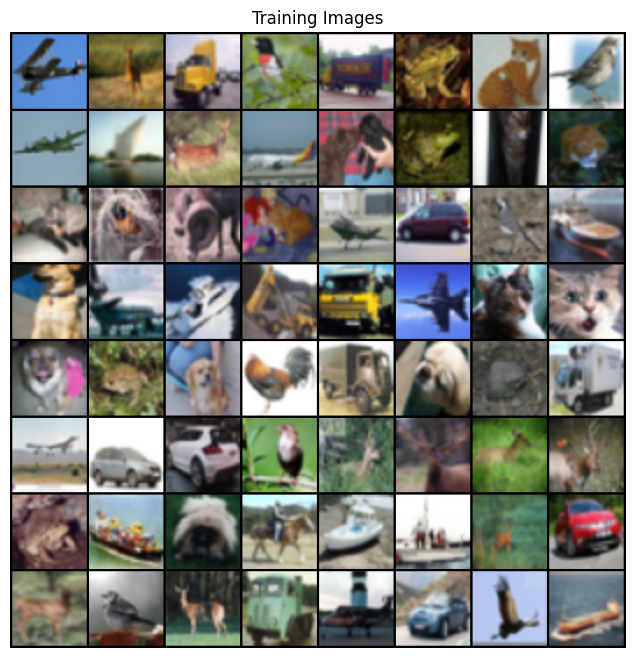

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
import torchvision
import torchvision.datasets as dset

dataroot="/content/drive/MyDrive/Cifar-10/cifar10/cifar-10-batches-py"
# Use CIFAR10 dataset instead of ImageFolder
dataset = torchvision.datasets.CIFAR10(root=dataroot,
                                       train=True,
                                       download=True,  # Since you already have it
                                       transform=transforms.Compose([
                                           transforms.Resize(image_size),
                                           transforms.CenterCrop(image_size),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Weight Initialization






In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [19]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [23]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [24]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [25]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Traing Code

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

**Generating 20 Images from random latent vector using checkpoint with 70 epochs**






Set random seed to 42 for reproducible results
Using device: cuda
Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth
Training epoch: 70
Generator loaded successfully!
Architecture: nz=100, ngf=64, nc=3
Generated latent vectors shape: torch.Size([20, 100, 1, 1])
Latent vector range: [-3.431, 3.036]

LATENT VECTORS:

Latent Vector 1:
Shape: torch.Size([100, 1, 1])
First 10 values: [ 0.1940188   2.1613736  -0.17205022  0.8490601  -1.924399    0.6529855
 -0.6494408  -0.81752473  0.5279645  -1.2753499 ]
Last 10 values: [-0.271873    0.27654943 -1.4398166  -0.64632124  0.07486922  0.19387875
  0.5960117   0.2322033   1.1414654  -0.681707  ]
Mean: -0.0217, Std: 0.9291
Min: -1.9244, Max: 2.3551
--------------------------------------------------

Latent Vector 2:
Shape: torch.Size([100, 1, 1])
First 10 values: [-1.6531448   0.00603564  1.381487    1.2704266   0.0232381  -1.3001451
 -0.75094134  0.37562433 -0.54744226 -0.03964127]
Last 10 values: 

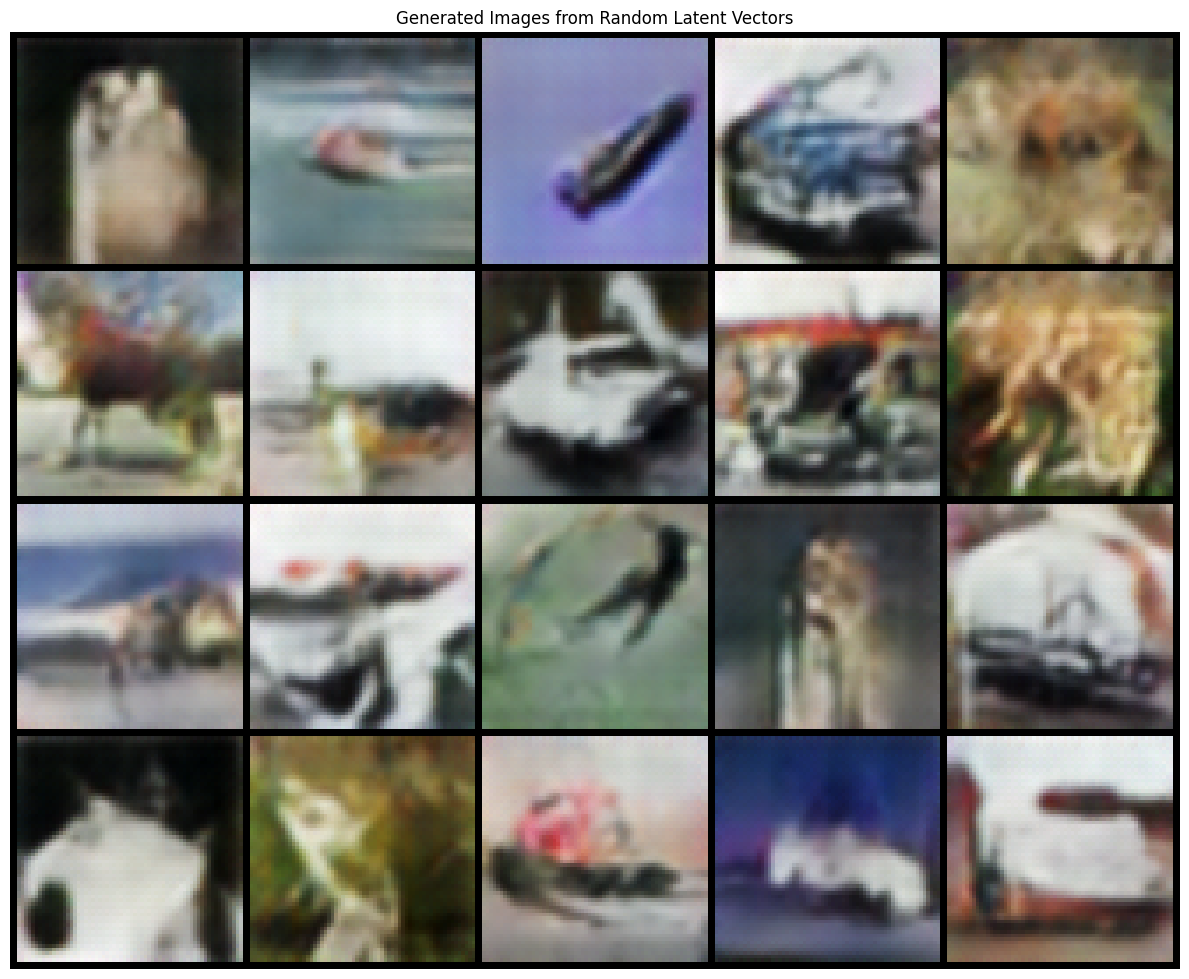


GENERATION SUMMARY
Number of images generated: 20
Latent vector shape: torch.Size([20, 100, 1, 1])
Generated image shape: torch.Size([20, 3, 64, 64])
Device used: cuda
Latent vectors saved: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Images saved in: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Grid image: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png

LATENT VECTOR STATISTICS:
  Mean: 0.0047
  Std: 1.0132
  Min: -3.4305
  Max: 3.0356

GENERATED IMAGE STATISTICS:
  Mean: -0.0183
  Std: 0.4391
  Min: -0.8972
  Max: 0.9183


In [25]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# DCGAN Generator class (based on your state_dict structure)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

def load_and_generate_images():
    """Load GAN generator and generate 20 images from random latent vectors"""

    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print(f"Set random seed to {seed} for reproducible results")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the checkpoint
    checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth"

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print(f"Checkpoint loaded successfully from: {checkpoint_path}")
        print(f"Training epoch: {checkpoint['epoch']}")

        # Create generator with inferred parameters
        # From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
        # This means: nz=100 (latent dim), ngf*8=512 so ngf=64
        nz = 100  # Latent dimension
        ngf = 64  # Generator feature maps
        nc = 3    # Number of channels (RGB)

        # Create and load generator
        netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netG.eval()

        print(f"Generator loaded successfully!")
        print(f"Architecture: nz={nz}, ngf={ngf}, nc={nc}")

    except Exception as e:
        print(f"Error loading generator: {e}")
        return None, None

    # Generate 20 random latent vectors
    num_images = 20

    # Generate random latent vectors from standard normal distribution
    # Shape: [batch_size, nz, 1, 1] for DCGAN
    latent_vectors = torch.randn(num_images, nz, 1, 1, device=device)

    print(f"Generated latent vectors shape: {latent_vectors.shape}")
    print(f"Latent vector range: [{latent_vectors.min():.3f}, {latent_vectors.max():.3f}]")

    # Print all latent vectors
    print("\nLATENT VECTORS:")
    print("="*70)

    for i in range(latent_vectors.shape[0]):
        print(f"\nLatent Vector {i+1}:")
        print(f"Shape: {latent_vectors[i].shape}")

        # Print the actual values (flattened for readability)
        vector_flat = latent_vectors[i].flatten()
        print(f"First 10 values: {vector_flat[:10].cpu().numpy()}")
        print(f"Last 10 values: {vector_flat[-10:].cpu().numpy()}")

        # Print statistics for this vector
        print(f"Mean: {vector_flat.mean():.4f}, Std: {vector_flat.std():.4f}")
        print(f"Min: {vector_flat.min():.4f}, Max: {vector_flat.max():.4f}")

        if i < 19:  # Add separator between vectors
            print("-" * 50)

    # Compact format summary
    print("\n\nCOMPACT SUMMARY:")
    print("="*70)
    for i in range(latent_vectors.shape[0]):
        vector_flat = latent_vectors[i].flatten()
        print(f"Vector {i+1:2d}: [{vector_flat[0]:.3f}, {vector_flat[1]:.3f}, {vector_flat[2]:.3f}, ..., {vector_flat[-1]:.3f}] (mean: {vector_flat.mean():.3f})")

    # Generate images
    with torch.no_grad():
        generated_images = netG(latent_vectors)
        print(f"\nGenerated images shape: {generated_images.shape}")
        print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

    # Save latent vectors
    latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
    torch.save(latent_vectors.cpu(), latent_save_path)
    print(f"Latent vectors saved to: {latent_save_path}")

    # Save generated images as individual files
    output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
    os.makedirs(output_dir, exist_ok=True)

    # Save each image individually
    for i in range(num_images):
        image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
        vutils.save_image(generated_images[i], image_path, normalize=True)

    print(f"Individual images saved to: {output_dir}")

    # Create and save a grid of all images
    grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
    grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
    vutils.save_image(grid, grid_path)
    print(f"Image grid saved to: {grid_path}")

    # Display the grid
    plt.figure(figsize=(12, 10))
    plt.axis("off")
    plt.title("Generated Images from Random Latent Vectors")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("GENERATION SUMMARY")
    print("="*50)
    print(f"Number of images generated: {num_images}")
    print(f"Latent vector shape: {latent_vectors.shape}")
    print(f"Generated image shape: {generated_images.shape}")
    print(f"Device used: {device}")
    print(f"Latent vectors saved: {latent_save_path}")
    print(f"Images saved in: {output_dir}")
    print(f"Grid image: {grid_path}")

    # Additional analysis
    print("\nLATENT VECTOR STATISTICS:")
    latent_flat = latent_vectors.flatten()
    print(f"  Mean: {latent_flat.mean():.4f}")
    print(f"  Std: {latent_flat.std():.4f}")
    print(f"  Min: {latent_flat.min():.4f}")
    print(f"  Max: {latent_flat.max():.4f}")

    print("\nGENERATED IMAGE STATISTICS:")
    image_flat = generated_images.flatten()
    print(f"  Mean: {image_flat.mean():.4f}")
    print(f"  Std: {image_flat.std():.4f}")
    print(f"  Min: {image_flat.min():.4f}")
    print(f"  Max: {image_flat.max():.4f}")

    return generated_images, latent_vectors

# Run the generation
generated_images, latent_vectors = load_and_generate_images()

**Generating 20 Images from random latent vector using checkpoint with 100 epochs**






Set random seed to 42 for reproducible results
Using device: cpu
Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_100.pth
Training epoch: 100
Generator loaded successfully!
Architecture: nz=100, ngf=64, nc=3
Generated latent vectors shape: torch.Size([20, 100, 1, 1])
Latent vector range: [-3.746, 2.876]

LATENT VECTORS:

Latent Vector 1:
Shape: torch.Size([100, 1, 1])
First 10 values: [-0.25208607  1.3950613   0.5603078  -0.65692794 -1.6711837  -1.4144932
 -1.2643857   0.5002061  -0.24135795 -2.5936038 ]
Last 10 values: [-0.28867555  2.4552612   1.5039197  -1.3081776  -0.6756909   1.2603115
  0.11611147  0.19171181 -0.30529755 -0.06996524]
Mean: -0.0487, Std: 0.9961
Min: -2.5936, Max: 2.4553
--------------------------------------------------

Latent Vector 2:
Shape: torch.Size([100, 1, 1])
First 10 values: [-0.10270829 -1.4345818  -0.9948659  -0.77567554  0.41423786  0.7452114
 -0.75348705 -1.9056408   0.04149207  1.4194232 ]
Last 10 values: 

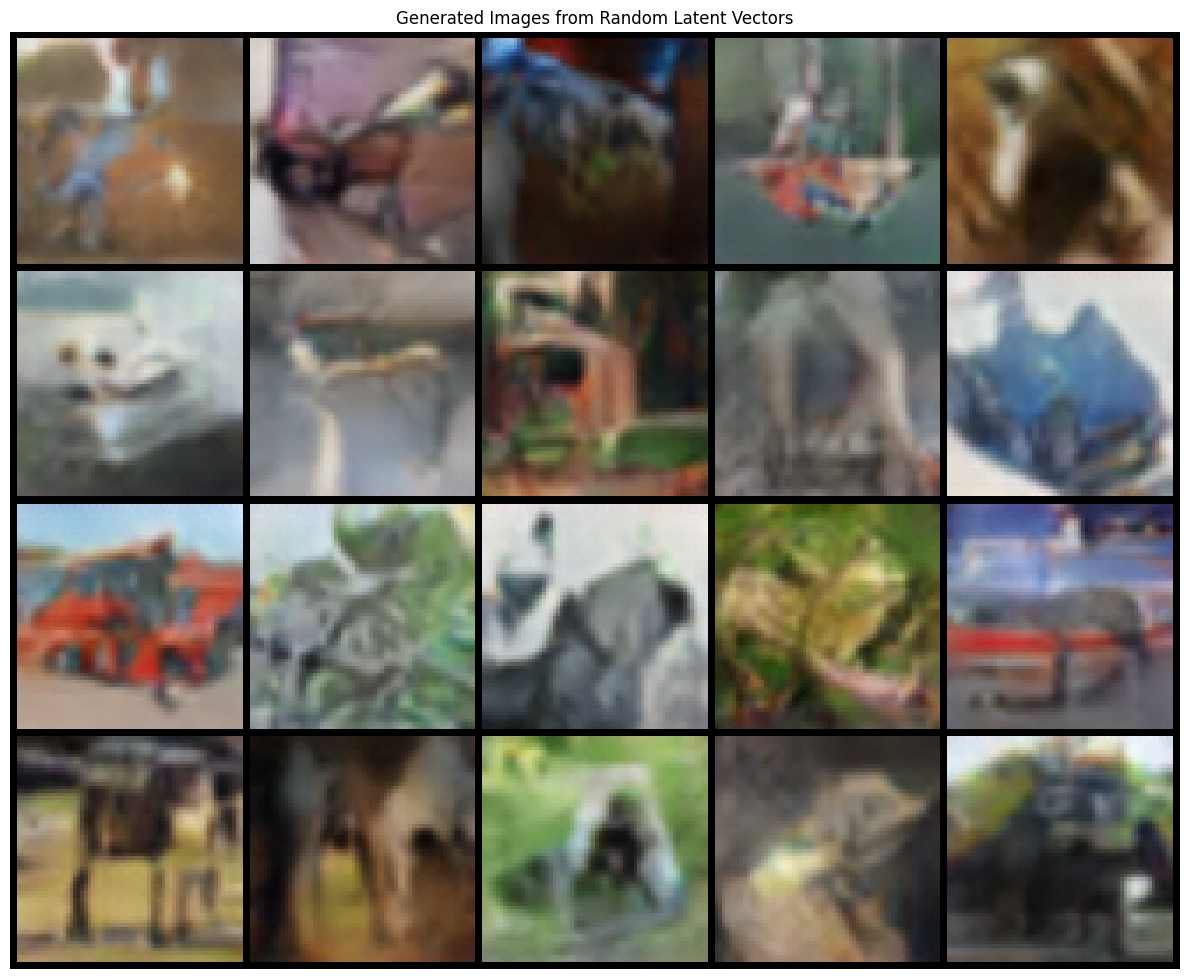


GENERATION SUMMARY
Number of images generated: 20
Latent vector shape: torch.Size([20, 100, 1, 1])
Generated image shape: torch.Size([20, 3, 64, 64])
Device used: cpu
Latent vectors saved: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Images saved in: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Grid image: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png

LATENT VECTOR STATISTICS:
  Mean: 0.0327
  Std: 0.9787
  Min: -3.7456
  Max: 2.8763

GENERATED IMAGE STATISTICS:
  Mean: -0.1288
  Std: 0.3393
  Min: -0.8421
  Max: 0.8661


In [26]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# DCGAN Generator class (based on your state_dict structure)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

def load_and_generate_images():
    """Load GAN generator and generate 20 images from random latent vectors"""

    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print(f"Set random seed to {seed} for reproducible results")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the checkpoint
    checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_100.pth"

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print(f"Checkpoint loaded successfully from: {checkpoint_path}")
        print(f"Training epoch: {checkpoint['epoch']}")

        # Create generator with inferred parameters
        # From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
        # This means: nz=100 (latent dim), ngf*8=512 so ngf=64
        nz = 100  # Latent dimension
        ngf = 64  # Generator feature maps
        nc = 3    # Number of channels (RGB)

        # Create and load generator
        netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netG.eval()

        print(f"Generator loaded successfully!")
        print(f"Architecture: nz={nz}, ngf={ngf}, nc={nc}")

    except Exception as e:
        print(f"Error loading generator: {e}")
        return None, None

    # Generate 20 random latent vectors
    num_images = 20

    # Generate random latent vectors from standard normal distribution
    # Shape: [batch_size, nz, 1, 1] for DCGAN
    latent_vectors = torch.randn(num_images, nz, 1, 1, device=device)

    print(f"Generated latent vectors shape: {latent_vectors.shape}")
    print(f"Latent vector range: [{latent_vectors.min():.3f}, {latent_vectors.max():.3f}]")

    # Print all latent vectors
    print("\nLATENT VECTORS:")
    print("="*70)

    for i in range(latent_vectors.shape[0]):
        print(f"\nLatent Vector {i+1}:")
        print(f"Shape: {latent_vectors[i].shape}")

        # Print the actual values (flattened for readability)
        vector_flat = latent_vectors[i].flatten()
        print(f"First 10 values: {vector_flat[:10].cpu().numpy()}")
        print(f"Last 10 values: {vector_flat[-10:].cpu().numpy()}")

        # Print statistics for this vector
        print(f"Mean: {vector_flat.mean():.4f}, Std: {vector_flat.std():.4f}")
        print(f"Min: {vector_flat.min():.4f}, Max: {vector_flat.max():.4f}")

        if i < 19:  # Add separator between vectors
            print("-" * 50)

    # Compact format summary
    print("\n\nCOMPACT SUMMARY:")
    print("="*70)
    for i in range(latent_vectors.shape[0]):
        vector_flat = latent_vectors[i].flatten()
        print(f"Vector {i+1:2d}: [{vector_flat[0]:.3f}, {vector_flat[1]:.3f}, {vector_flat[2]:.3f}, ..., {vector_flat[-1]:.3f}] (mean: {vector_flat.mean():.3f})")

    # Generate images
    with torch.no_grad():
        generated_images = netG(latent_vectors)
        print(f"\nGenerated images shape: {generated_images.shape}")
        print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

    # Save latent vectors
    latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
    torch.save(latent_vectors.cpu(), latent_save_path)
    print(f"Latent vectors saved to: {latent_save_path}")

    # Save generated images as individual files
    output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
    os.makedirs(output_dir, exist_ok=True)

    # Save each image individually
    for i in range(num_images):
        image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
        vutils.save_image(generated_images[i], image_path, normalize=True)

    print(f"Individual images saved to: {output_dir}")

    # Create and save a grid of all images
    grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
    grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
    vutils.save_image(grid, grid_path)
    print(f"Image grid saved to: {grid_path}")

    # Display the grid
    plt.figure(figsize=(12, 10))
    plt.axis("off")
    plt.title("Generated Images from Random Latent Vectors")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("GENERATION SUMMARY")
    print("="*50)
    print(f"Number of images generated: {num_images}")
    print(f"Latent vector shape: {latent_vectors.shape}")
    print(f"Generated image shape: {generated_images.shape}")
    print(f"Device used: {device}")
    print(f"Latent vectors saved: {latent_save_path}")
    print(f"Images saved in: {output_dir}")
    print(f"Grid image: {grid_path}")

    # Additional analysis
    print("\nLATENT VECTOR STATISTICS:")
    latent_flat = latent_vectors.flatten()
    print(f"  Mean: {latent_flat.mean():.4f}")
    print(f"  Std: {latent_flat.std():.4f}")
    print(f"  Min: {latent_flat.min():.4f}")
    print(f"  Max: {latent_flat.max():.4f}")

    print("\nGENERATED IMAGE STATISTICS:")
    image_flat = generated_images.flatten()
    print(f"  Mean: {image_flat.mean():.4f}")
    print(f"  Std: {image_flat.std():.4f}")
    print(f"  Min: {image_flat.min():.4f}")
    print(f"  Max: {image_flat.max():.4f}")

    return generated_images, latent_vectors

# Run the generation
generated_images, latent_vectors = load_and_generate_images()

**Generating 20 Images from random latent vector using checkpoint with 170 epochs**






Set random seed to 42 for reproducible results
Using device: cpu
Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_170.pth
Training epoch: 170
Generator loaded successfully!
Architecture: nz=100, ngf=64, nc=3
Generated latent vectors shape: torch.Size([20, 100, 1, 1])
Latent vector range: [-3.746, 2.876]

LATENT VECTORS:


COMPACT SUMMARY:
Vector  1: [-0.252, 1.395, 0.560, ..., -0.070] (mean: -0.049)
Vector  2: [-0.103, -1.435, -0.995, ..., 1.412] (mean: 0.005)
Vector  3: [-1.246, 0.143, 1.779, ..., -1.239] (mean: 0.112)
Vector  4: [0.095, 1.117, 0.599, ..., -1.733] (mean: 0.108)
Vector  5: [-0.192, 0.990, 0.368, ..., 0.105] (mean: 0.059)
Vector  6: [0.135, 0.492, 1.132, ..., -0.028] (mean: 0.062)
Vector  7: [0.668, -0.472, 1.578, ..., -0.012] (mean: -0.033)
Vector  8: [-0.339, 0.767, -1.754, ..., 1.005] (mean: -0.159)
Vector  9: [-1.316, 1.221, -0.796, ..., 0.118] (mean: -0.014)
Vector 10: [-0.840, 0.424, 0.747, ..., -1.699] (mean: 0.119)
Vec

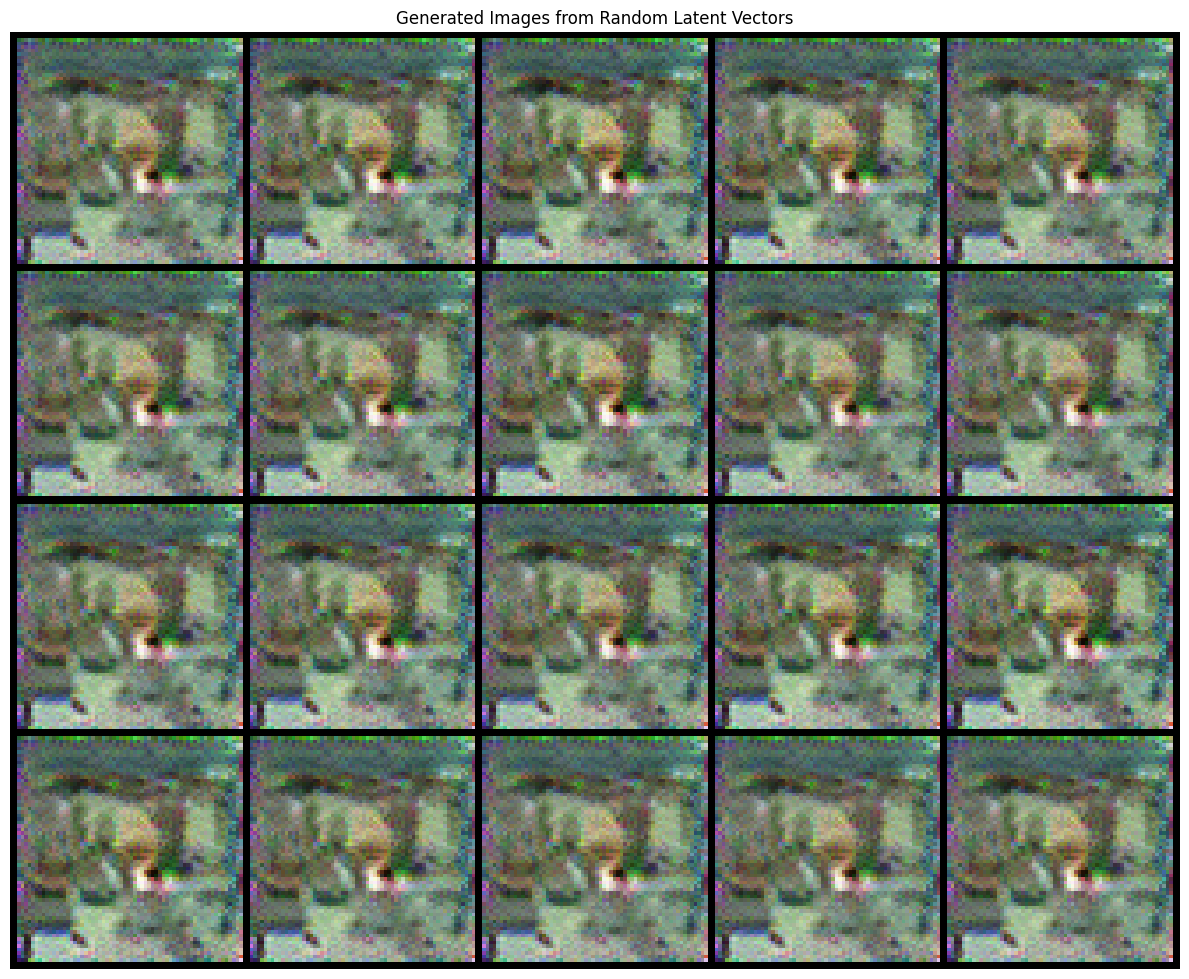


GENERATION SUMMARY
Number of images generated: 20
Latent vector shape: torch.Size([20, 100, 1, 1])
Generated image shape: torch.Size([20, 3, 64, 64])
Device used: cpu
Latent vectors saved: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Images saved in: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Grid image: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png

LATENT VECTOR STATISTICS:
  Mean: 0.0327
  Std: 0.9787
  Min: -3.7456
  Max: 2.8763

GENERATED IMAGE STATISTICS:
  Mean: -0.1020
  Std: 0.2906
  Min: -0.9673
  Max: 0.9845


In [27]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# DCGAN Generator class (based on your state_dict structure)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

def load_and_generate_images():
    """Load GAN generator and generate 20 images from random latent vectors"""

    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print(f"Set random seed to {seed} for reproducible results")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the checkpoint
    checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_170.pth"

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print(f"Checkpoint loaded successfully from: {checkpoint_path}")
        print(f"Training epoch: {checkpoint['epoch']}")

        # Create generator with inferred parameters
        # From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
        # This means: nz=100 (latent dim), ngf*8=512 so ngf=64
        nz = 100  # Latent dimension
        ngf = 64  # Generator feature maps
        nc = 3    # Number of channels (RGB)

        # Create and load generator
        netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netG.eval()

        print(f"Generator loaded successfully!")
        print(f"Architecture: nz={nz}, ngf={ngf}, nc={nc}")

    except Exception as e:
        print(f"Error loading generator: {e}")
        return None, None

    # Generate 20 random latent vectors
    num_images = 20

    # Generate random latent vectors from standard normal distribution
    # Shape: [batch_size, nz, 1, 1] for DCGAN
    latent_vectors = torch.randn(num_images, nz, 1, 1, device=device)

    print(f"Generated latent vectors shape: {latent_vectors.shape}")
    print(f"Latent vector range: [{latent_vectors.min():.3f}, {latent_vectors.max():.3f}]")

    # Print all latent vectors
    print("\nLATENT VECTORS:")
    print("="*70)


    # Compact format summary
    print("\n\nCOMPACT SUMMARY:")
    print("="*70)
    for i in range(latent_vectors.shape[0]):
        vector_flat = latent_vectors[i].flatten()
        print(f"Vector {i+1:2d}: [{vector_flat[0]:.3f}, {vector_flat[1]:.3f}, {vector_flat[2]:.3f}, ..., {vector_flat[-1]:.3f}] (mean: {vector_flat.mean():.3f})")

    # Generate images
    with torch.no_grad():
        generated_images = netG(latent_vectors)
        print(f"\nGenerated images shape: {generated_images.shape}")
       # print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

    # Save latent vectors
    latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
    torch.save(latent_vectors.cpu(), latent_save_path)
    print(f"Latent vectors saved to: {latent_save_path}")

    # Save generated images as individual files
    output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
    os.makedirs(output_dir, exist_ok=True)

    # Save each image individually
    for i in range(num_images):
        image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
        vutils.save_image(generated_images[i], image_path, normalize=True)

    print(f"Individual images saved to: {output_dir}")

    # Create and save a grid of all images
    grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
    grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
    vutils.save_image(grid, grid_path)
    print(f"Image grid saved to: {grid_path}")

    # Display the grid
    plt.figure(figsize=(12, 10))
    plt.axis("off")
    plt.title("Generated Images from Random Latent Vectors")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("GENERATION SUMMARY")
    print("="*50)
    print(f"Number of images generated: {num_images}")
    print(f"Latent vector shape: {latent_vectors.shape}")
    print(f"Generated image shape: {generated_images.shape}")
    print(f"Device used: {device}")
    print(f"Latent vectors saved: {latent_save_path}")
    print(f"Images saved in: {output_dir}")
    print(f"Grid image: {grid_path}")

    # Additional analysis
    print("\nLATENT VECTOR STATISTICS:")
    latent_flat = latent_vectors.flatten()
    print(f"  Mean: {latent_flat.mean():.4f}")
    print(f"  Std: {latent_flat.std():.4f}")
    print(f"  Min: {latent_flat.min():.4f}")
    print(f"  Max: {latent_flat.max():.4f}")

    print("\nGENERATED IMAGE STATISTICS:")
    image_flat = generated_images.flatten()
    print(f"  Mean: {image_flat.mean():.4f}")
    print(f"  Std: {image_flat.std():.4f}")
    print(f"  Min: {image_flat.min():.4f}")
    print(f"  Max: {image_flat.max():.4f}")

    return generated_images, latent_vectors

# Run the generation
generated_images, latent_vectors = load_and_generate_images()

Taking two random latent vectors that produce two distinct images and interpolate between the two.


Generated images shape: torch.Size([2, 3, 64, 64])
Latent vectors saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Individual images saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Image grid saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png


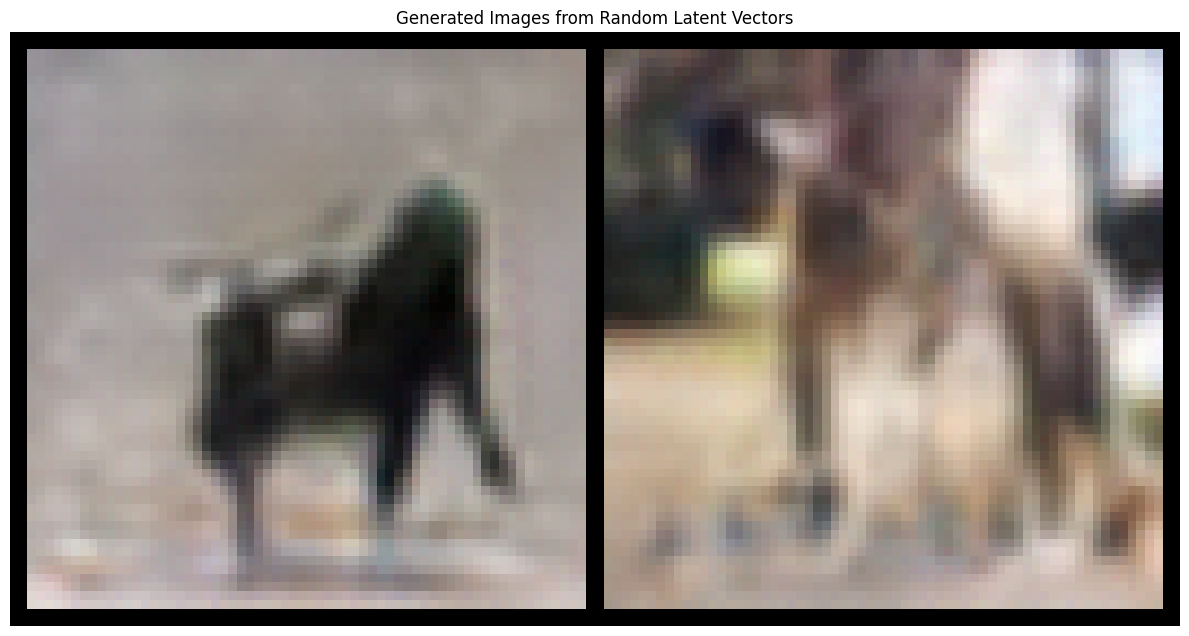

In [28]:
torch.manual_seed(42)
latent_vector = torch.randn(2, 100, 1, 1,device=device)
latent_vector.shape

checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_100.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
nz = 100  # Latent dimension
ngf = 64  # Generator feature maps
nc = 3    # Number of channels (RGB)

# Create and load generator
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()
with torch.no_grad():
    generated_images = netG(latent_vector)
    print(f"\nGenerated images shape: {generated_images.shape}")
    # print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

# Save latent vectors
latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
torch.save(latent_vectors.cpu(), latent_save_path)
print(f"Latent vectors saved to: {latent_save_path}")

num_images = generated_images.shape[0]
# Save generated images as individual files
output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Save each image individually
for i in range(num_images):
    image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
    vutils.save_image(generated_images[i], image_path, normalize=True)

print(f"Individual images saved to: {output_dir}")

# Create and save a grid of all images
grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
vutils.save_image(grid, grid_path)
print(f"Image grid saved to: {grid_path}")

# Display the grid
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Generated Images from Random Latent Vectors")
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()


Interpolation Testing

torch.Size([10, 100, 1, 1])

Generated images shape: torch.Size([10, 3, 64, 64])
Latent vectors saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Individual images saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Image grid saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png


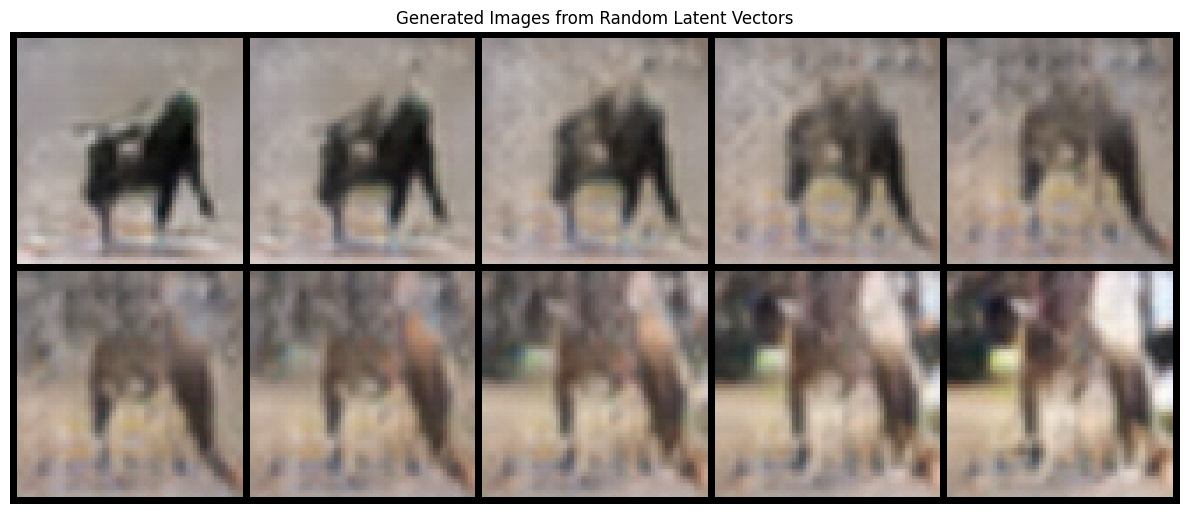

In [29]:
# Fix syntax first
torch.manual_seed(42)
latent_vector = torch.randn(2, 100, 1, 1, device=device)

# Interpolate between the two vectors
num_steps = 10
alphas = torch.linspace(0, 1, num_steps, device=device)

interpolated_vectors = []
for alpha in alphas:
    interp = (1 - alpha) * latent_vector[0] + alpha * latent_vector[1]
    interpolated_vectors.append(interp.unsqueeze(0))

interpolated_vectors = torch.cat(interpolated_vectors, dim=0)
print(interpolated_vectors.shape)  # Should be [10, 100, 1, 1]

netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()
with torch.no_grad():
    generated_images = netG(interpolated_vectors)
    print(f"\nGenerated images shape: {generated_images.shape}")
    # print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

# Save latent vectors
latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
torch.save(latent_vectors.cpu(), latent_save_path)
print(f"Latent vectors saved to: {latent_save_path}")

num_images = generated_images.shape[0]
# Save generated images as individual files
output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Save each image individually
for i in range(num_images):
    image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
    vutils.save_image(generated_images[i], image_path, normalize=True)

print(f"Individual images saved to: {output_dir}")

# Create and save a grid of all images
grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
vutils.save_image(grid, grid_path)
print(f"Image grid saved to: {grid_path}")

# Display the grid
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Generated Images from Random Latent Vectors")
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()


# OOD Noise: ood_latents_exp


Generated images shape: torch.Size([20, 3, 64, 64])
Latent vectors saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Individual images saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Image grid saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png


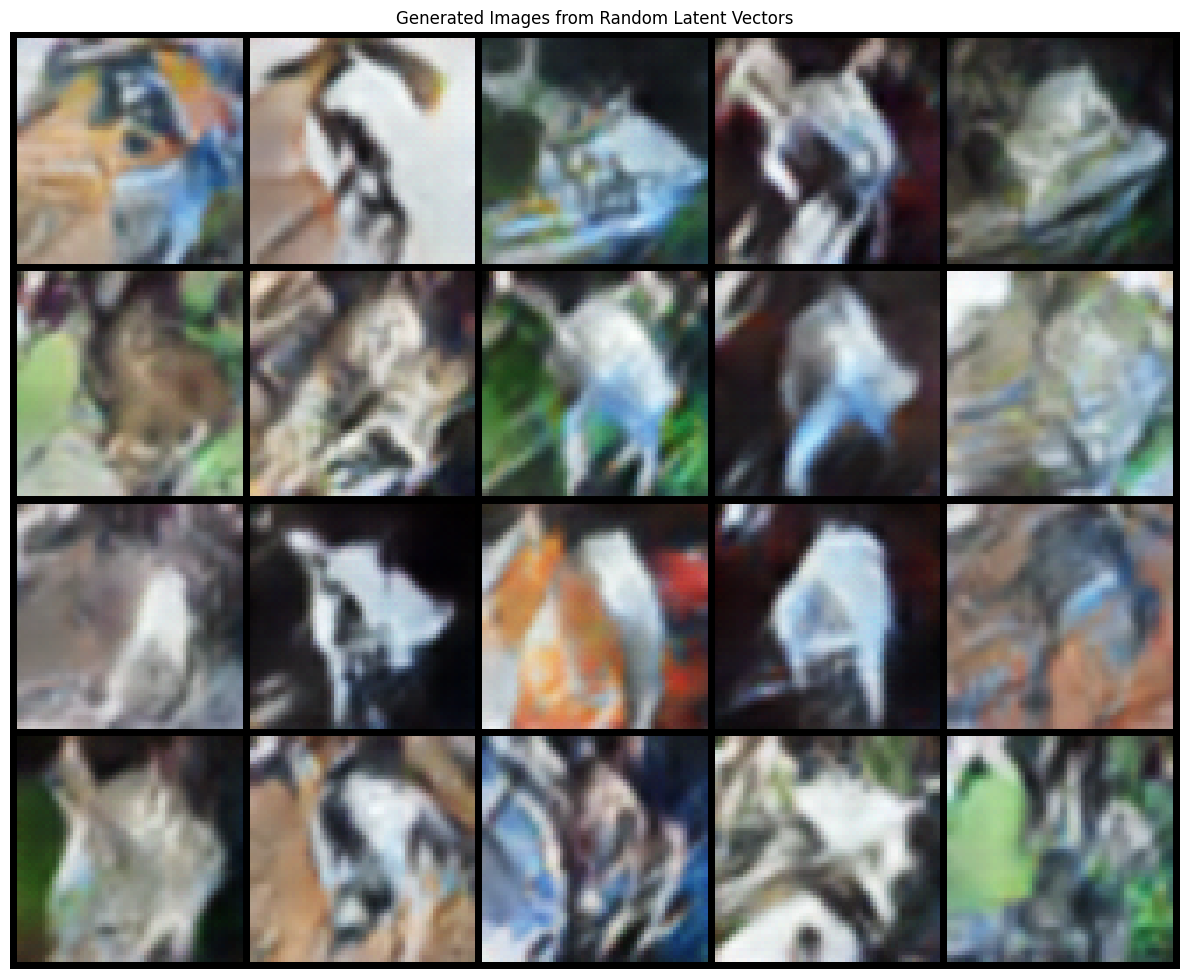

In [ ]:
torch.manual_seed(42)

# Option 1: Uniform distribution [-3, 3]
ood_latents_uniform = torch.rand(20, 100, 1, 1, device=device) * 6 - 3

# Option 2: Exponential distribution (fixed)
ood_latents_exp = torch.distributions.Exponential(1.0).sample((20, 100, 1, 1)).to(device)

# Option 3: Beta distribution (skewed)
ood_latents_beta = torch.distributions.Beta(0.5, 0.5).sample((20, 100, 1, 1)).to(device)

ood_list = [  ood_latents_uniform, ood_latents_exp, ood_latents_beta]
nz= 100
ngf = 64
nc = 3
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()
with torch.no_grad():
    generated_images = netG(ood_latents_exp)
    print(f"\nGenerated images shape: {generated_images.shape}")
    # print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

# Save latent vectors
latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
torch.save(latent_vectors.cpu(), latent_save_path)
print(f"Latent vectors saved to: {latent_save_path}")

num_images = generated_images.shape[0]
# Save generated images as individual files
output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Save each image individually
for i in range(num_images):
    image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
    vutils.save_image(generated_images[i], image_path, normalize=True)

print(f"Individual images saved to: {output_dir}")

# Create and save a grid of all images
grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
vutils.save_image(grid, grid_path)
print(f"Image grid saved to: {grid_path}")

# Display the grid
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Generated Images from Random Latent Vectors")
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()



# OOD noise: ood_latents_beta


Generated images shape: torch.Size([20, 3, 64, 64])
Latent vectors saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt
Individual images saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images
Image grid saved to: /content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png


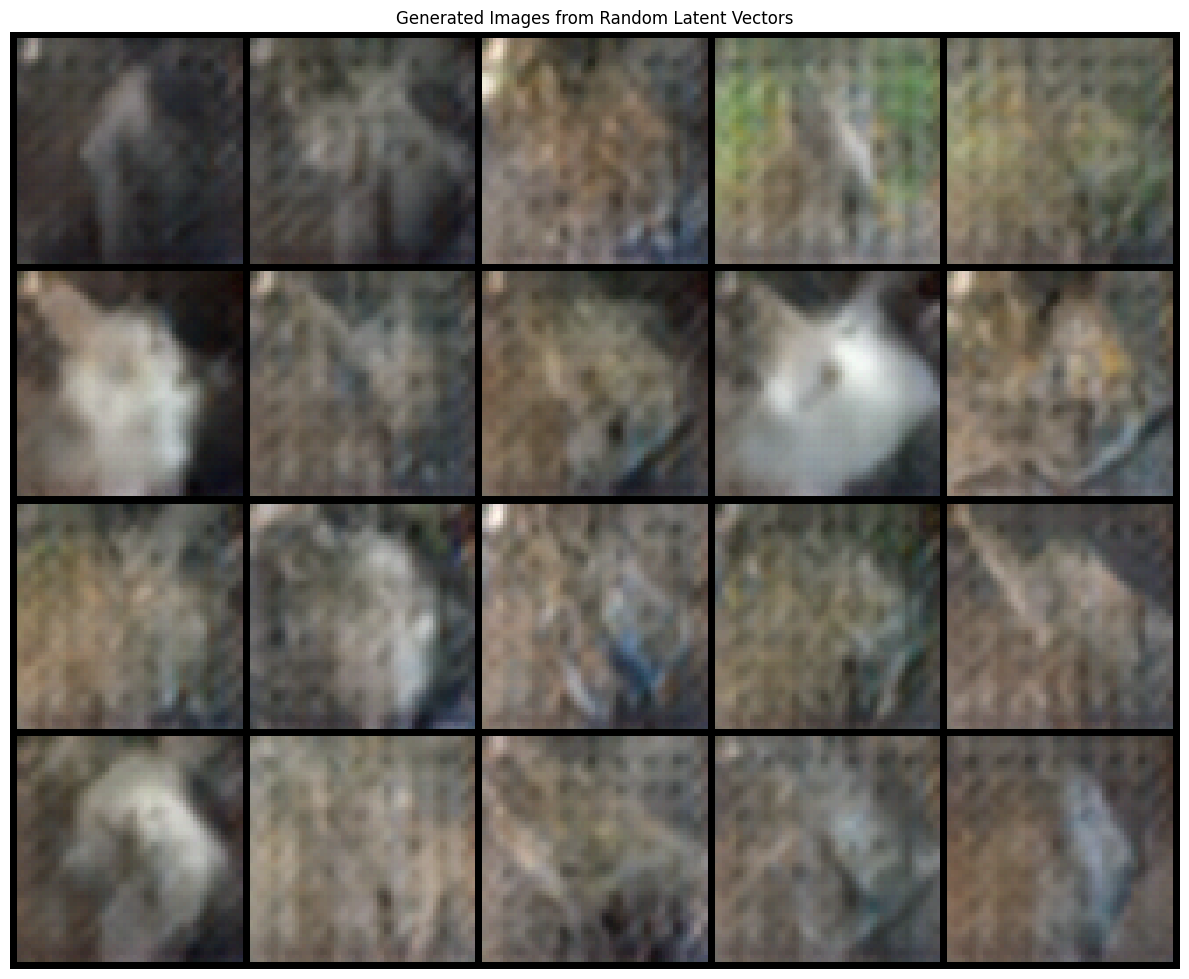

In [31]:
torch.manual_seed(42)

# Option 1: Uniform distribution [-3, 3]
ood_latents_uniform = torch.rand(20, 100, 1, 1, device=device) * 6 - 3

# Option 2: Exponential distribution (fixed)
ood_latents_exp = torch.distributions.Exponential(1.0).sample((20, 100, 1, 1)).to(device)

# Option 3: Beta distribution (skewed)
ood_latents_beta = torch.distributions.Beta(0.5, 0.5).sample((20, 100, 1, 1)).to(device)

ood_list = [  ood_latents_uniform, ood_latents_exp, ood_latents_beta]
nz= 100
ngf = 64
nc = 3
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()
with torch.no_grad():
    generated_images = netG(ood_latents_beta)
    print(f"\nGenerated images shape: {generated_images.shape}")
    # print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

# Save latent vectors
latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_latent_vectors.pt"
torch.save(latent_vectors.cpu(), latent_save_path)
print(f"Latent vectors saved to: {latent_save_path}")

num_images = generated_images.shape[0]
# Save generated images as individual files
output_dir = "/content/drive/MyDrive/GAN_Checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Save each image individually
for i in range(num_images):
    image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
    vutils.save_image(generated_images[i], image_path, normalize=True)

print(f"Individual images saved to: {output_dir}")

# Create and save a grid of all images
grid_path = "/content/drive/MyDrive/GAN_Checkpoints/generated_images_grid.png"
grid = vutils.make_grid(generated_images, nrow=5, normalize=True, padding=2)
vutils.save_image(grid, grid_path)
print(f"Image grid saved to: {grid_path}")

# Display the grid
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Generated Images from Random Latent Vectors")
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()

